In [9]:
import time
from collections import Counter
from scipy.io import loadmat
from scipy import signal
from itertools import groupby
import matplotlib
from operator import itemgetter
import os
import seaborn as sns
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys
sys.path.insert(0, r'..\tools')
from scan import scan_sort
from EM_detection import find_peak
from zscore import zscore
from smooth import smooth,ins_smooth,de_sampling

In [10]:
def normalized_time(data,time_window):
    # plt.subplots(1,2,figsize=(6,2))
    index_data = np.where(np.array(data) > 0.5)[0]
    per_inde = index_data / len(data)
    ins = np.zeros(time_window)
    ins[np.ceil(per_inde * len(ins)).astype(int)] = 1

    len_normalized=np.where(np.array(ins)>0.5)[0]
    # plt.subplot(121);plt.plot(ins);plt.scatter(len_normalized,ins[len_normalized],c='r')
    # plt.subplot(122);plt.plot(data)
    # print(f'原始数据满足要求的数量：{len(index_data)},normarlized后的数量： {len(len_normalized)}')
    return ins

In [11]:
'''
    raster_data is input dataset;
    n is the row number of input raster_data
    out_path is the directory of exported file
    dataset_type=list
    defualt: n=6
'''

###参考：https://matplotlib.org/stable/gallery/lines_bars_and_markers/eventplot_demo.html#sphx-glr-gallery-lines-bars-and-markers-eventplot-demo-py
def raster_plot(raster_data,n,out_path:Path):
    matplotlib.rcParams['font.size'] = 8.0

    out_path=Path(out_path)

    data1 =raster_data

    # set different colors for each set of positions
    colors1 = ['C{}'.format(i) for i in range(n)]

    # set different line properties for each set of positions
    # note that some overlap
    lineoffsets1 = [i for i in range(n)]
    linelengths1 = [0.5]*n

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

    # create a horizontal plot
    axs[2]=axs[0].twinx()
    axs[0].eventplot(data1, colors=colors1, lineoffsets=lineoffsets1, linelengths=linelengths1)

    # create a vertical plot
    flat_em_raster=[j for i in data1 for j in i]
    axs[1].hist(flat_em_raster,bins=40,histtype='stepfilled',facecolor='dodgerblue', alpha=0.5)
    # axs[1].eventplot(data1, colors=colors1, lineoffsets=lineoffsets1, linelengths=linelengths1, orientation='vertical')

    axs[2].hist(flat_em_raster, bins=40, histtype='step', stacked=True, fill=False)
    axs[2].set_title('stack step (unfilled)')
    if is_save=='yes':
        plt.savefig(str(newPath) + '\\' + 'em_raster.pdf', bbox_inches='tight')

    plt.show()

In [12]:
###查找满足REM-off或则t_pREM转变的marker点
def fiber_mice(i):
    Ca,Sleep,EM=i
    file=str(Ca[-15:])

    Ch488=pd.read_table(Ca, sep=',').Ch488.astype(float).tolist()
    Ch408=pd.read_table(Ca, sep=',').Ch408.astype(float).tolist()
    Ch488 = zscore(Ch488,Ch488)   ###baseline的位置   int(len(response)*0.25)
    Ch408= zscore(Ch408, Ch408)
    Ch488=signal.detrend(Ch488, axis=0, type='linear', bp=0, overwrite_data=False)
    Ch408=signal.detrend(Ch408, axis=0, type='linear', bp=0, overwrite_data=False)

    plt.figure(figsize=(9,3),dpi=300)
    plt.plot(range(len(Ch488)),Ch488,lw=1,c='black');plt.plot(range(len(Ch488)),Ch488,lw=1,c='red');plt.show()
    ###read the stage and em data
    Stage=pd.read_table(Sleep,skiprows=18, sep='\t').Stage.astype(str)
    Stage=Stage.replace({'W':0,'NR':5,'R':10})

    em=pd.read_table(EM,sep=',').EM.values

    length=min(len(Ch488)//400,len(Stage))
    Stage=Stage[:length]
    EM=em[:length*2000]

    Ch488=Ch488[:length*400]
    Ca_list=Ch488.reshape((-1,400))

    episodes= {'0':[],'5':[],'10':[]}
    wake_index=[x[0] for x in enumerate(Stage) if x[1]==0]
    nrem_index=[x[0] for x in enumerate(Stage) if x[1]==5]
    rem_index=[x[0] for x in enumerate(Stage) if x[1]==10]

    # print(f"W_index:{wake_index}")
    for k, g in groupby(enumerate(wake_index),lambda x:x[0]-x[1]):
        group=list(map(itemgetter(1), g))
        episodes['0'].append((group[0], group[-1]+1))
    for k, g in groupby(enumerate(nrem_index),lambda x:x[0]-x[1]):
        group=list(map(itemgetter(1), g))
        episodes['5'].append((group[0], group[-1]+1))
    for k, g in groupby(enumerate(rem_index),lambda x:x[0]-x[1]):
        group=list(map(itemgetter(1), g))
        episodes['10'].append((group[0], group[-1]+1))

    em_fre=pd.read_csv(os.path.dirname(newPath)+f'\\em_fre{file}',sep=',').em_fre.values
    em_fre=np.array(em_fre)

    em_index=pd.read_csv(os.path.dirname(newPath)+f'\\em_index{file}',sep=',').em_index.values
    em_index_list=np.array(em_index).reshape((-1,2000))
    print({f'一共有多少眼动{np.sum(em_index)}'})

    valid_episode=0
    Ca_trial,em_trial=[],[]
    ###分析特定状态转变期间钙信号和眼动
    for start, end in episodes['10'][:-1]:    ###不同转变状态需修改

        idx =[idx_i for idx_i in np.arange(start, end)]
        # print(np.array(Stage)[idx])
        epoch_n=[]
        ###转变后无眼动
        # for num in [idx_i for idx_i in np.arange(end, end+len(idx))]:        #  NREM-tonicREM需要更改np.arange(end, end+len(idx),1):
        #     if sum(em_index_list[num])!=0:
        #         epoch_n.append(1)
        #     else:
        #         epoch_n.append(0)
        ###转变前无眼动
        # for num in idx:        #  NREM-tonicREM需要更改np.arange(end, end+len(idx),1):
        #     if sum(em_index_list[num])!=0:
        #         epoch_n.append(1)
        #     else:
        #         epoch_n.append(0)

        if sum(epoch_n)>=0 and 2<=len(idx)<=max_epoch and Stage[end]==0:    ###不同转变状态需修改,tonicREM状态需要增加条件sum(epoch_n)<=0 and
            valid_episode+=1
            normalized_time_len=max_epoch*2*2000
            ###nomarlize time in em index
            em_index_episode_i =em_index_list[start:end+len(idx)].flatten()
            # _,ins_em=ins_smooth(range(len(em_index_episode_i)),em_index_episode_i,normalized_time_len)
            ins_em=normalized_time(em_index_episode_i,normalized_time_len)

            ###nomarlize time in cell activity across transition
            stage_data = Ca_list[start:end+len(idx)].flatten()
            _,ins_ca=ins_smooth(range(len(stage_data)),stage_data,normalized_time_len)

            em_trial.append(ins_em)
            Ca_trial.append(ins_ca)

            all_cell['em'].append(ins_em)
            all_cell['cell'].append(ins_ca)
            all_cell['mean_before'].append(np.mean(ins_ca[:len(ins_ca)//2]))
            all_cell['mean_after'].append(np.mean(ins_ca[len(ins_ca)//2:]))
        else:
            continue
        ###提取各个trial的反应均值
    if len(em_trial)!=0:
        mean_trial_em=np.sum(em_trial,axis=0)
        mean_Ca_em=np.mean(Ca_trial,axis=0)
        all_trial['trial_name'].append(file)
        all_trial['mean_em_before'].append(np.sum(mean_trial_em[:len(mean_trial_em)//2]))
        all_trial['mean_em_after'].append(np.sum(mean_trial_em[len(mean_trial_em)//2:]))
        all_trial['mean_Ca_before'].append(np.mean(mean_Ca_em[:len(mean_Ca_em)//2]))
        all_trial['mean_Ca_after'].append(np.mean(mean_Ca_em[len(mean_Ca_em)//2:]))
    return

('rawdata\\mice1#\\fiber1\\mice1#_1fiber.txt', 'rawdata\\mice1#\\sleep1\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice1#\\sleep1\\modify_sleeprawdata.txt')


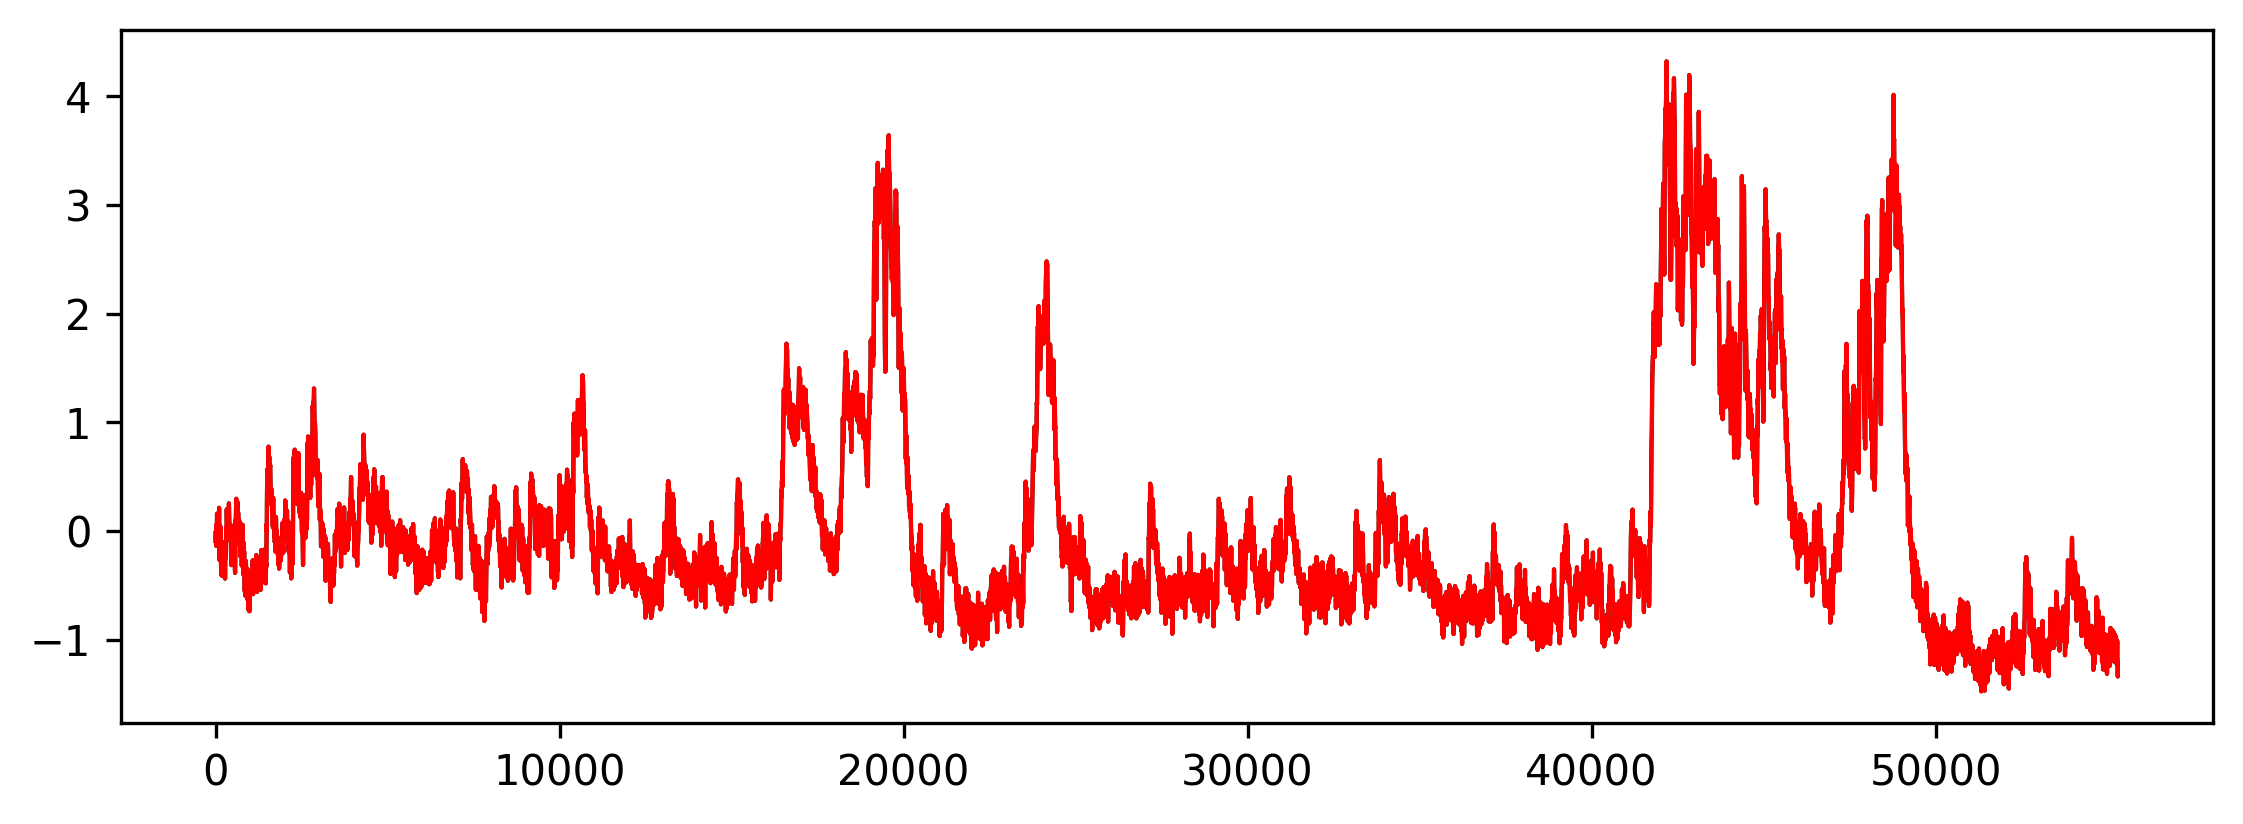

{'一共有多少眼动370'}
('rawdata\\mice1#\\fiber2\\mice1#_2fiber.txt', 'rawdata\\mice1#\\sleep2\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice1#\\sleep2\\modify_sleeprawdata.txt')


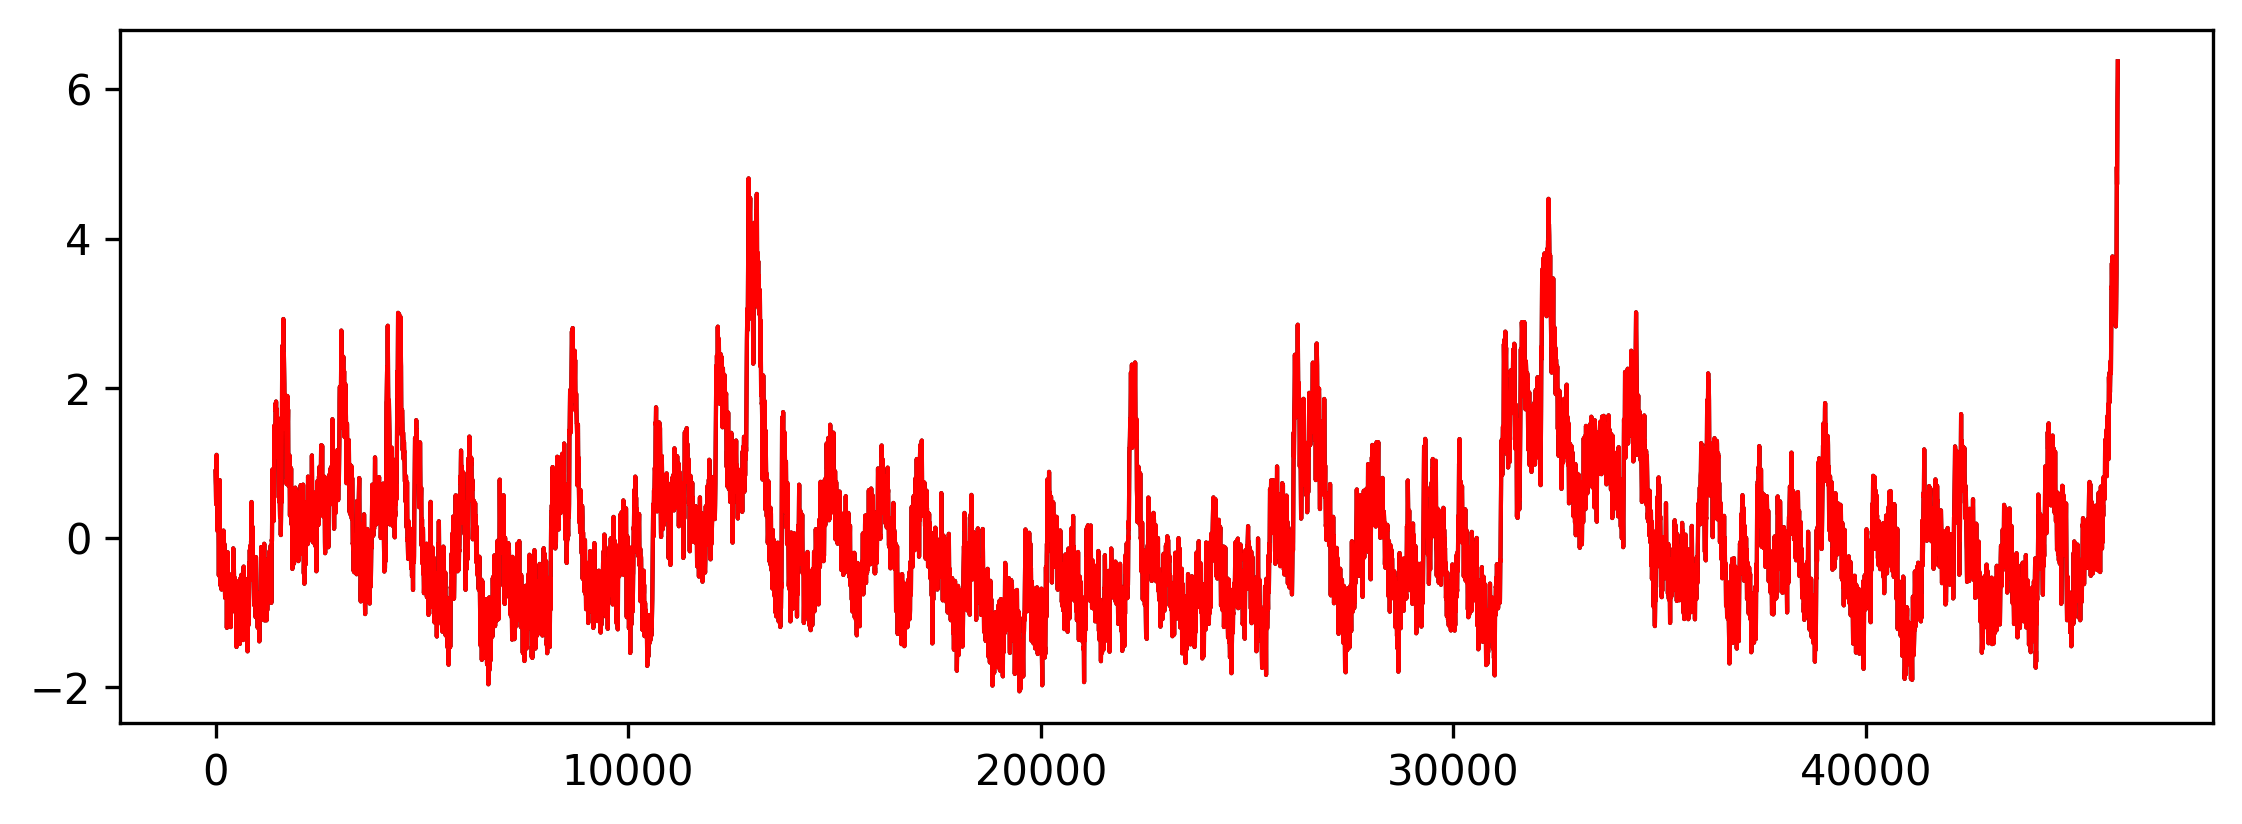

{'一共有多少眼动488'}
('rawdata\\mice1#\\fiber3\\mice1#_3fiber.txt', 'rawdata\\mice1#\\sleep3\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice1#\\sleep3\\modify_sleeprawdata.txt')


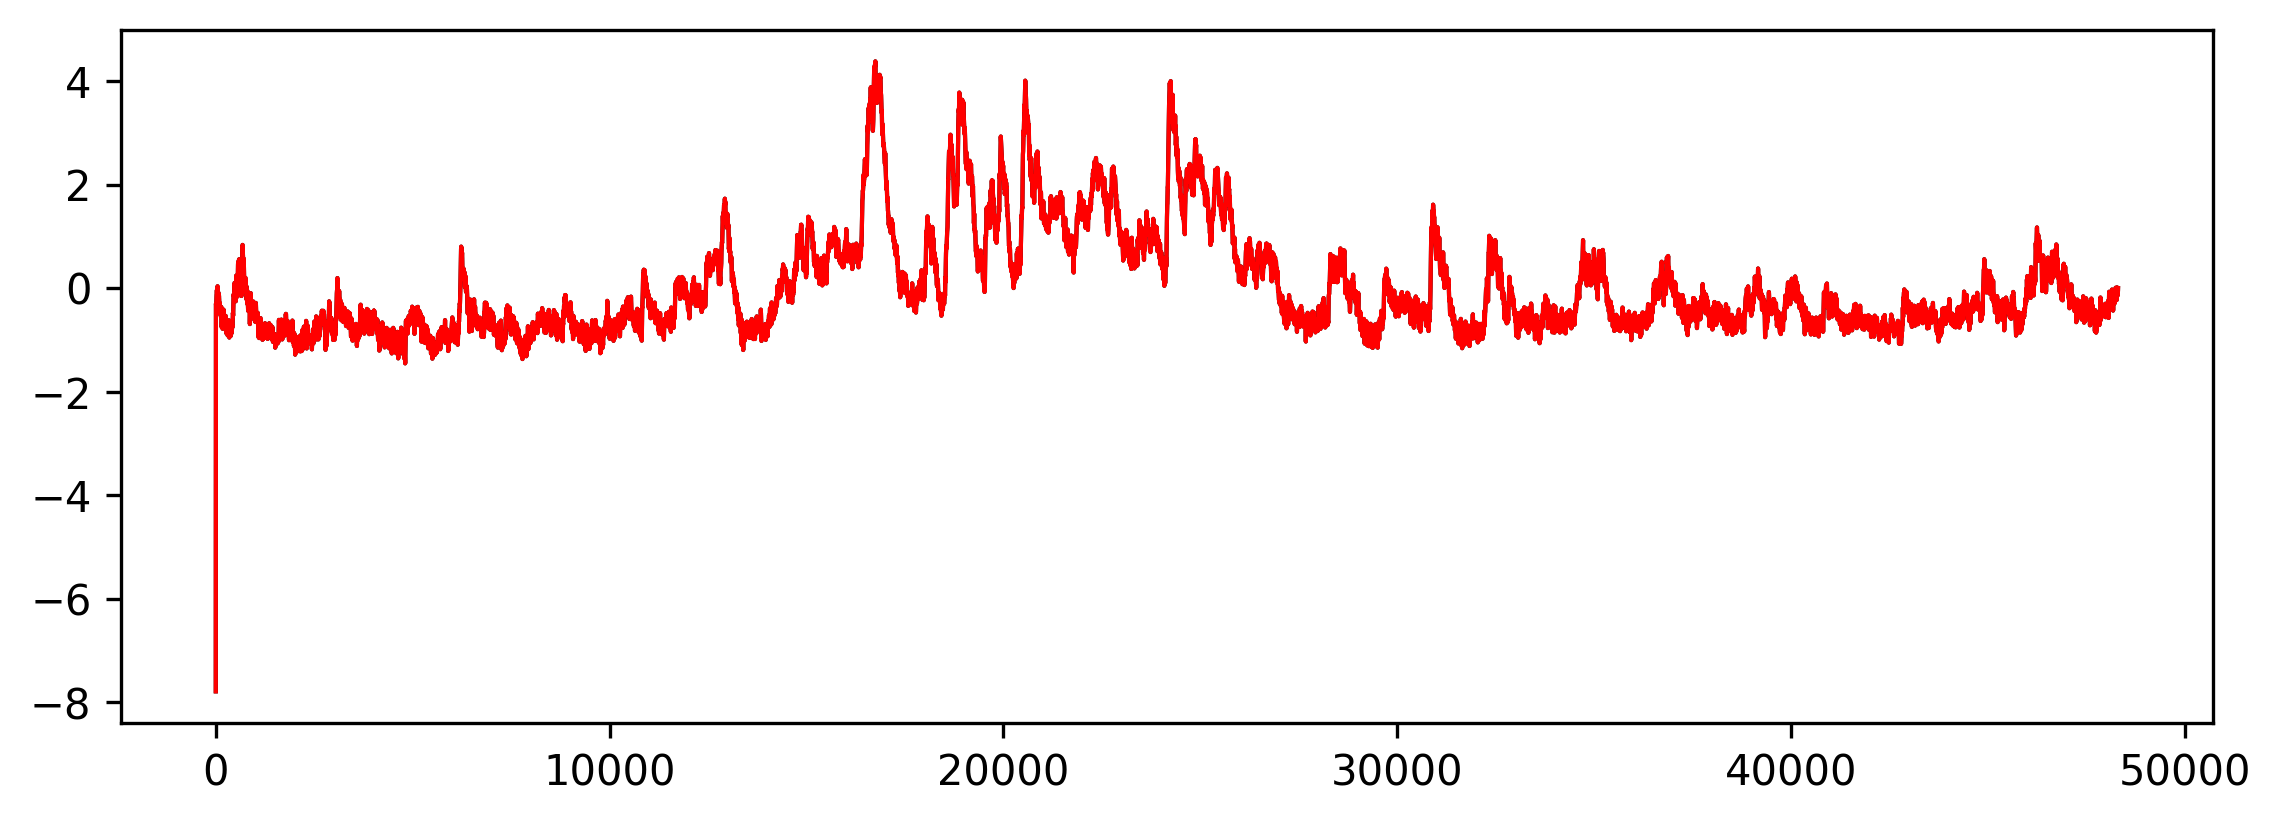

{'一共有多少眼动359'}
('rawdata\\mice2#\\fiber1\\mice2#_1fiber.txt', 'rawdata\\mice2#\\sleep1\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice2#\\sleep1\\modify_sleeprawdata.txt')


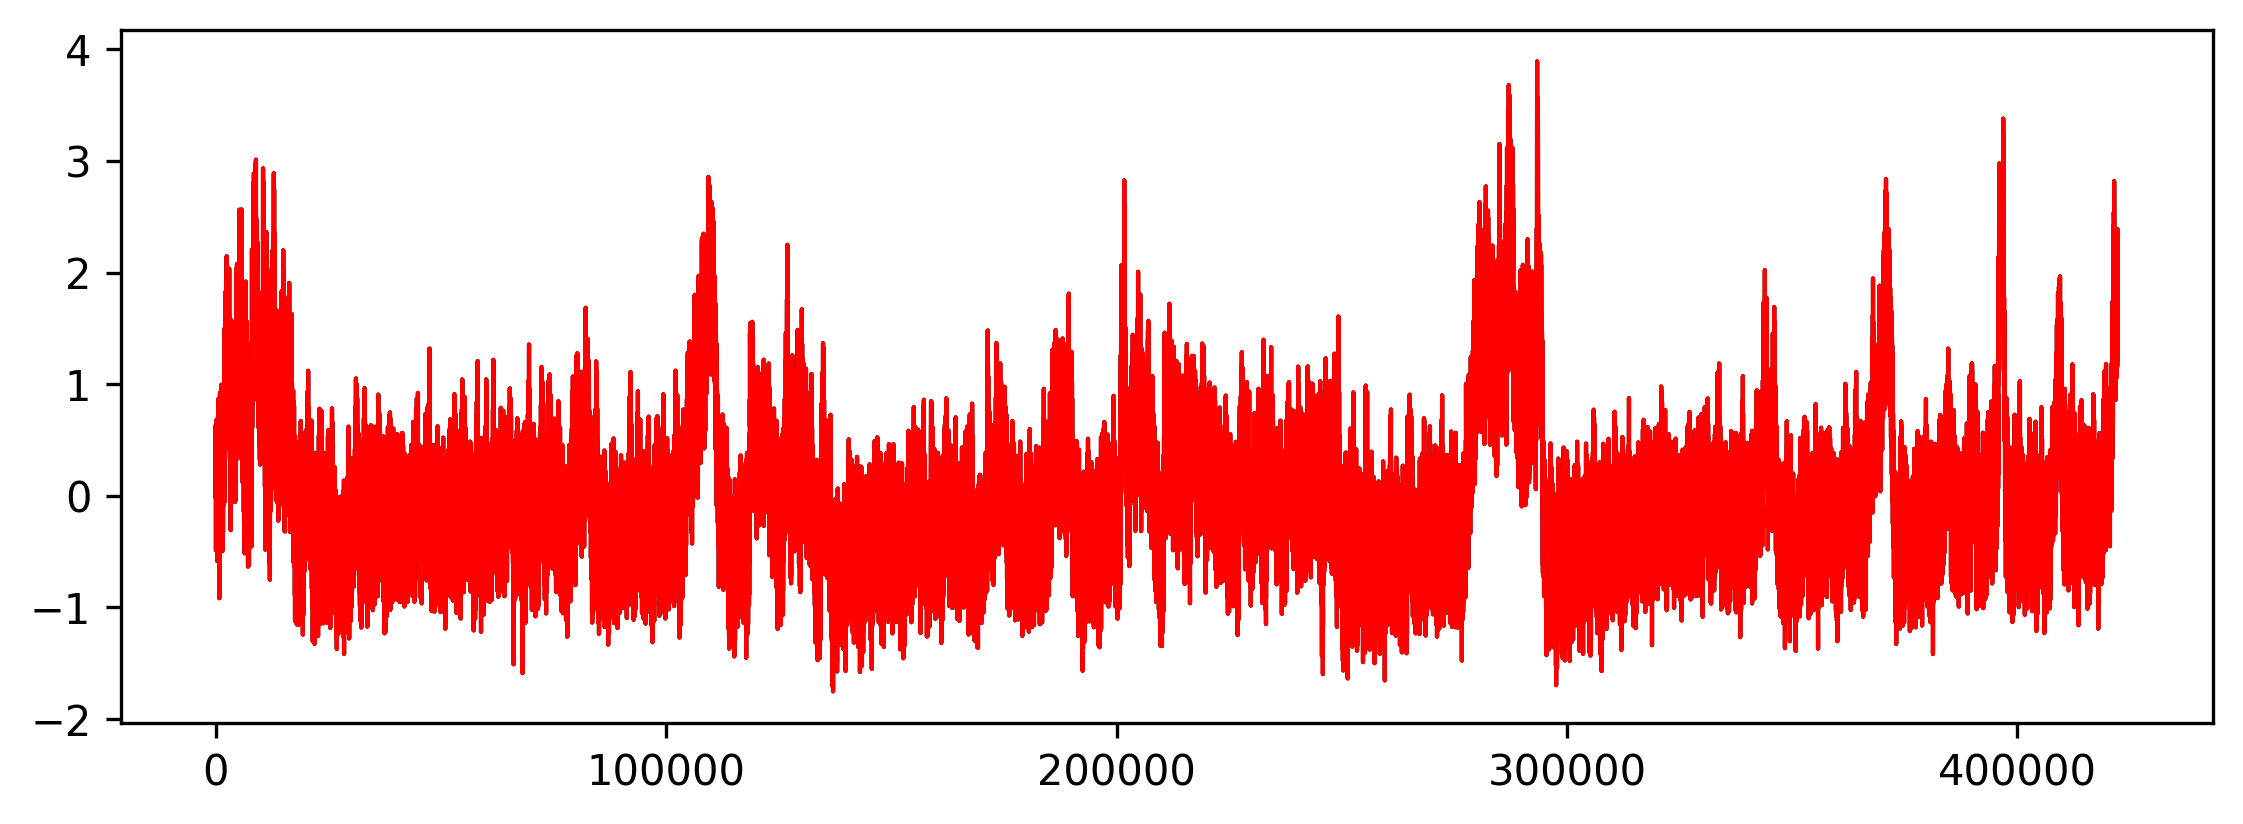

{'一共有多少眼动2819'}
('rawdata\\mice2#\\fiber2\\mice2#_2fiber.txt', 'rawdata\\mice2#\\sleep2\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice2#\\sleep2\\modify_sleeprawdata.txt')


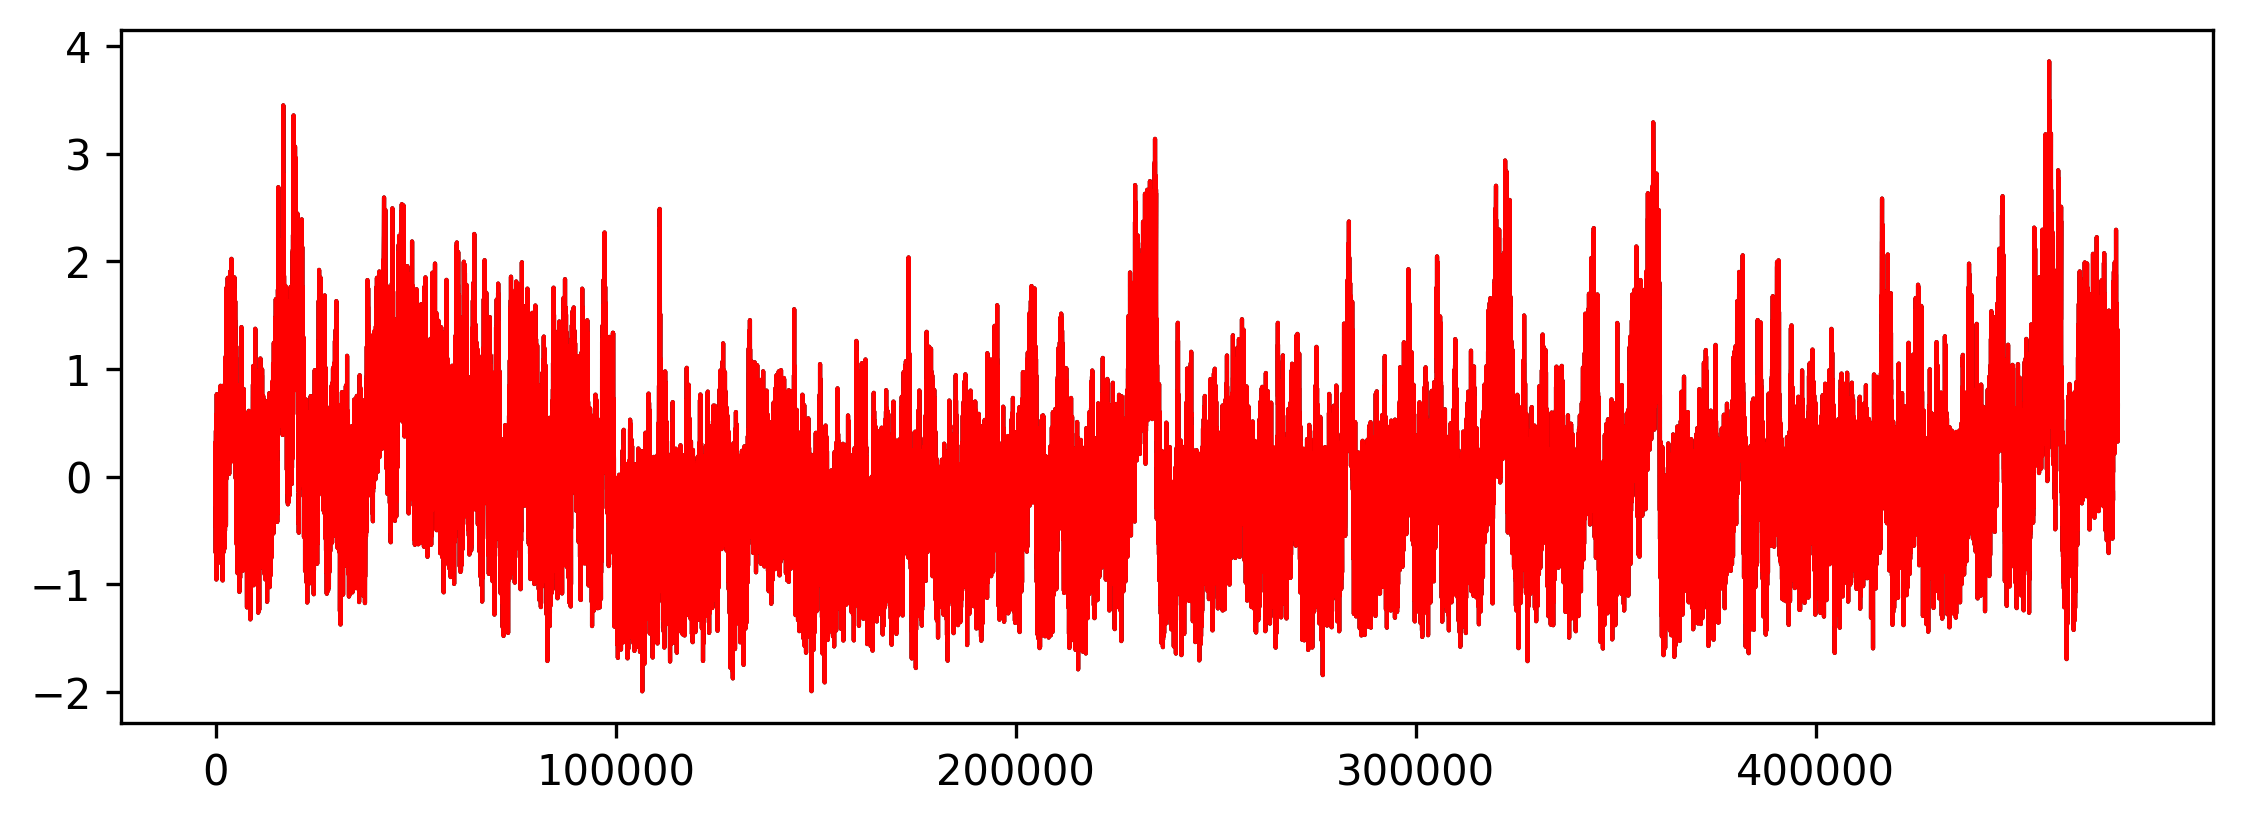

{'一共有多少眼动3546'}
('rawdata\\mice2#\\fiber3\\mice2#_3fiber.txt', 'rawdata\\mice2#\\sleep3\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice2#\\sleep3\\modify_sleeprawdata.txt')


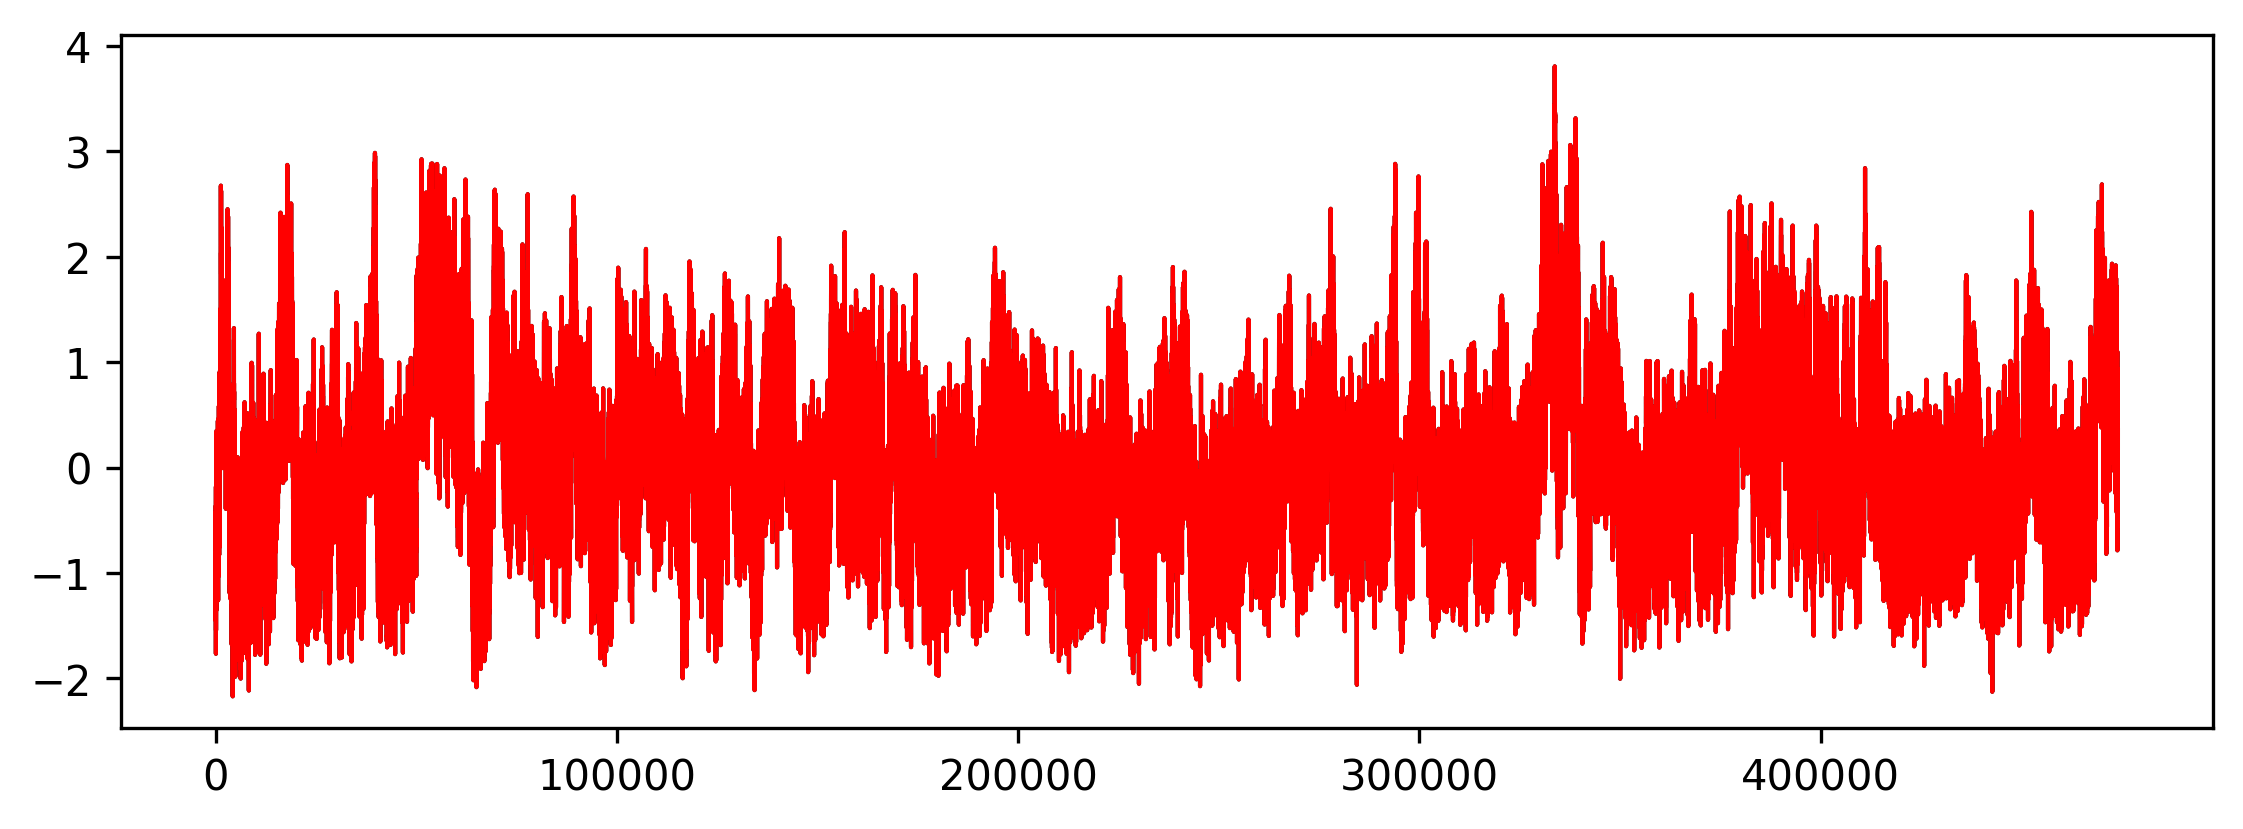

{'一共有多少眼动4359'}
('rawdata\\mice4#\\fiber4\\mice4#_4fiber.txt', 'rawdata\\mice4#\\sleep4\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice4#\\sleep4\\modify_sleeprawdata.txt')


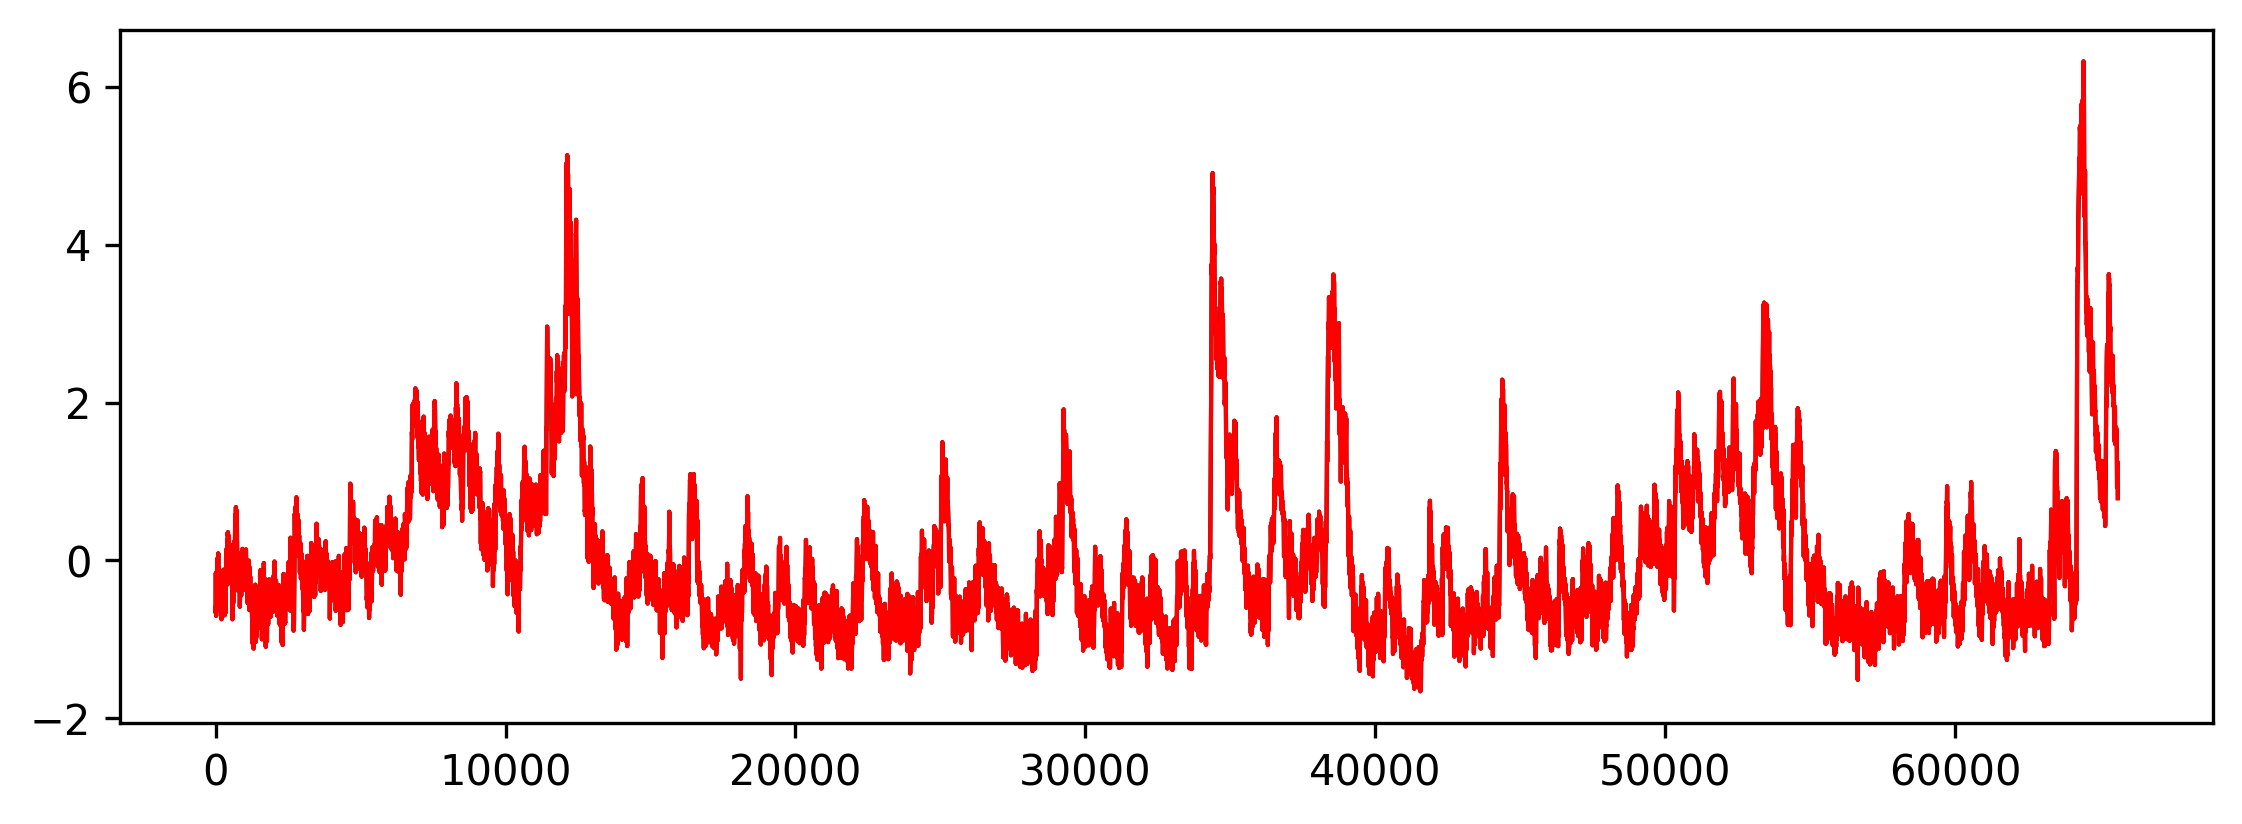

{'一共有多少眼动396'}
('rawdata\\mice4#\\fiber5\\mice4#_5fiber.txt', 'rawdata\\mice4#\\sleep5\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice4#\\sleep5\\modify_sleeprawdata.txt')


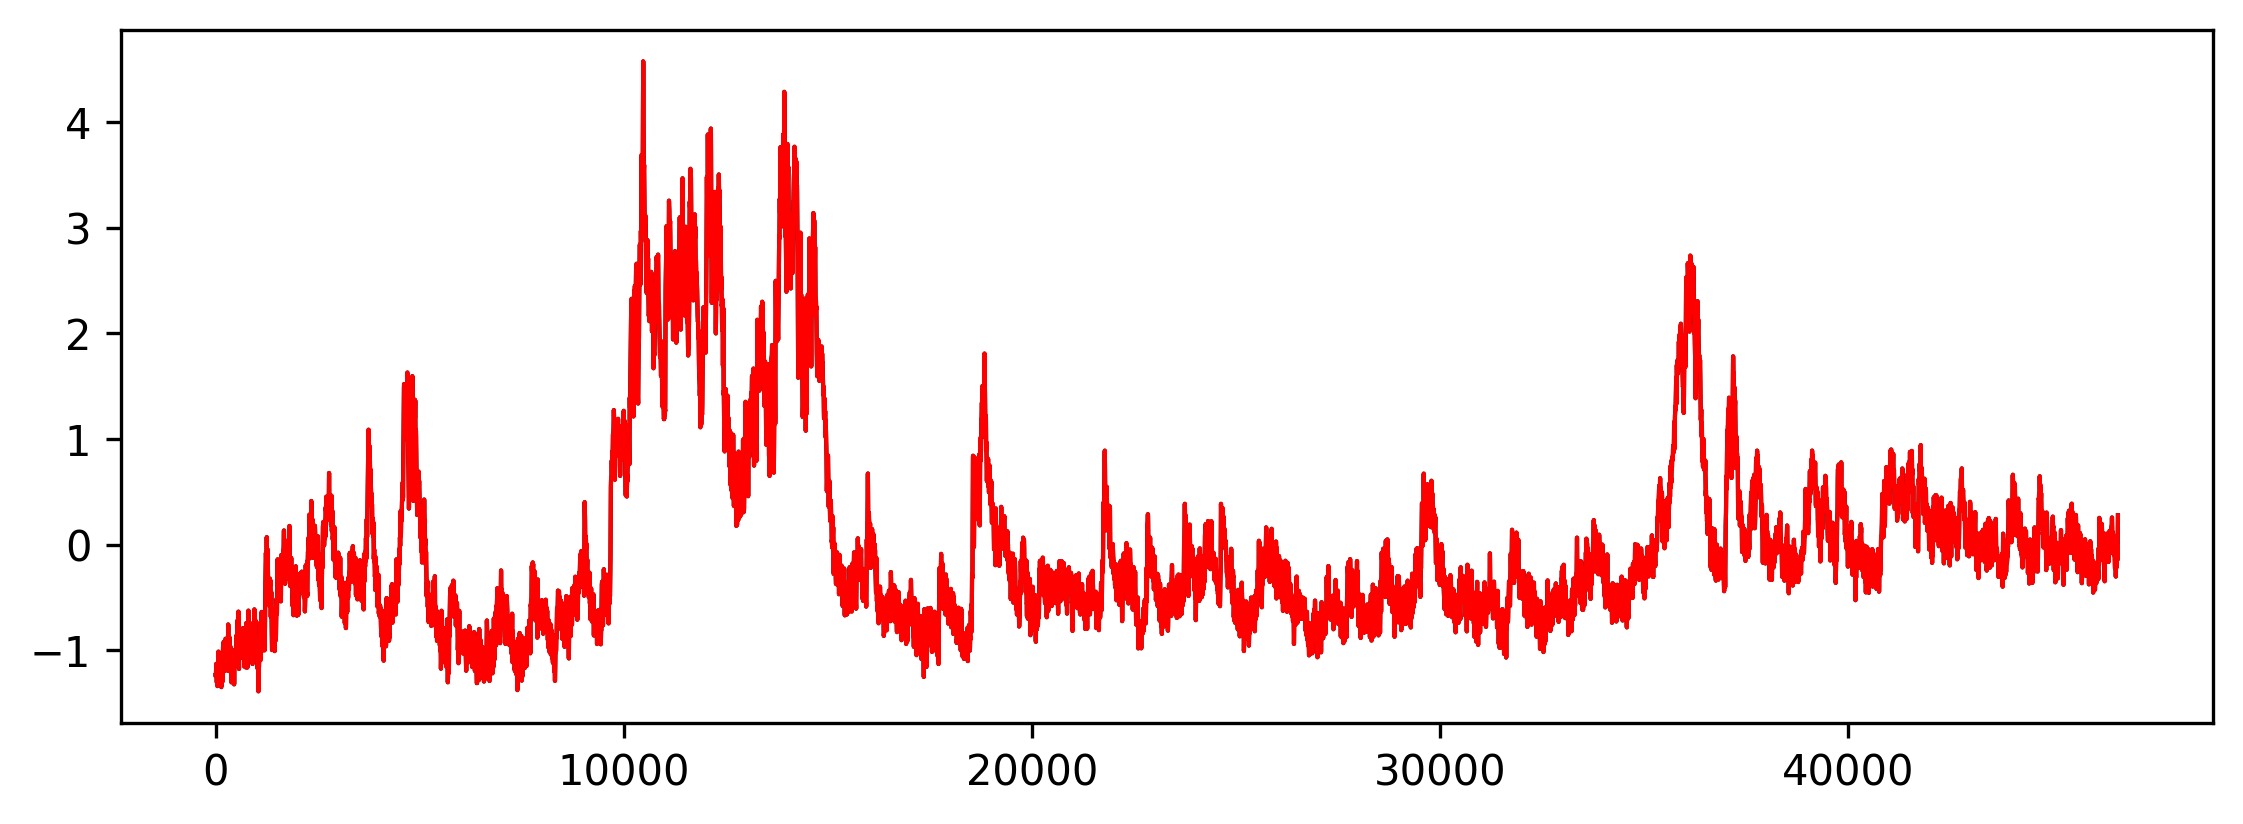

{'一共有多少眼动332'}
('rawdata\\mice4#\\fiber6\\mice4#_6fiber.txt', 'rawdata\\mice4#\\sleep6\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice4#\\sleep6\\modify_sleeprawdata.txt')


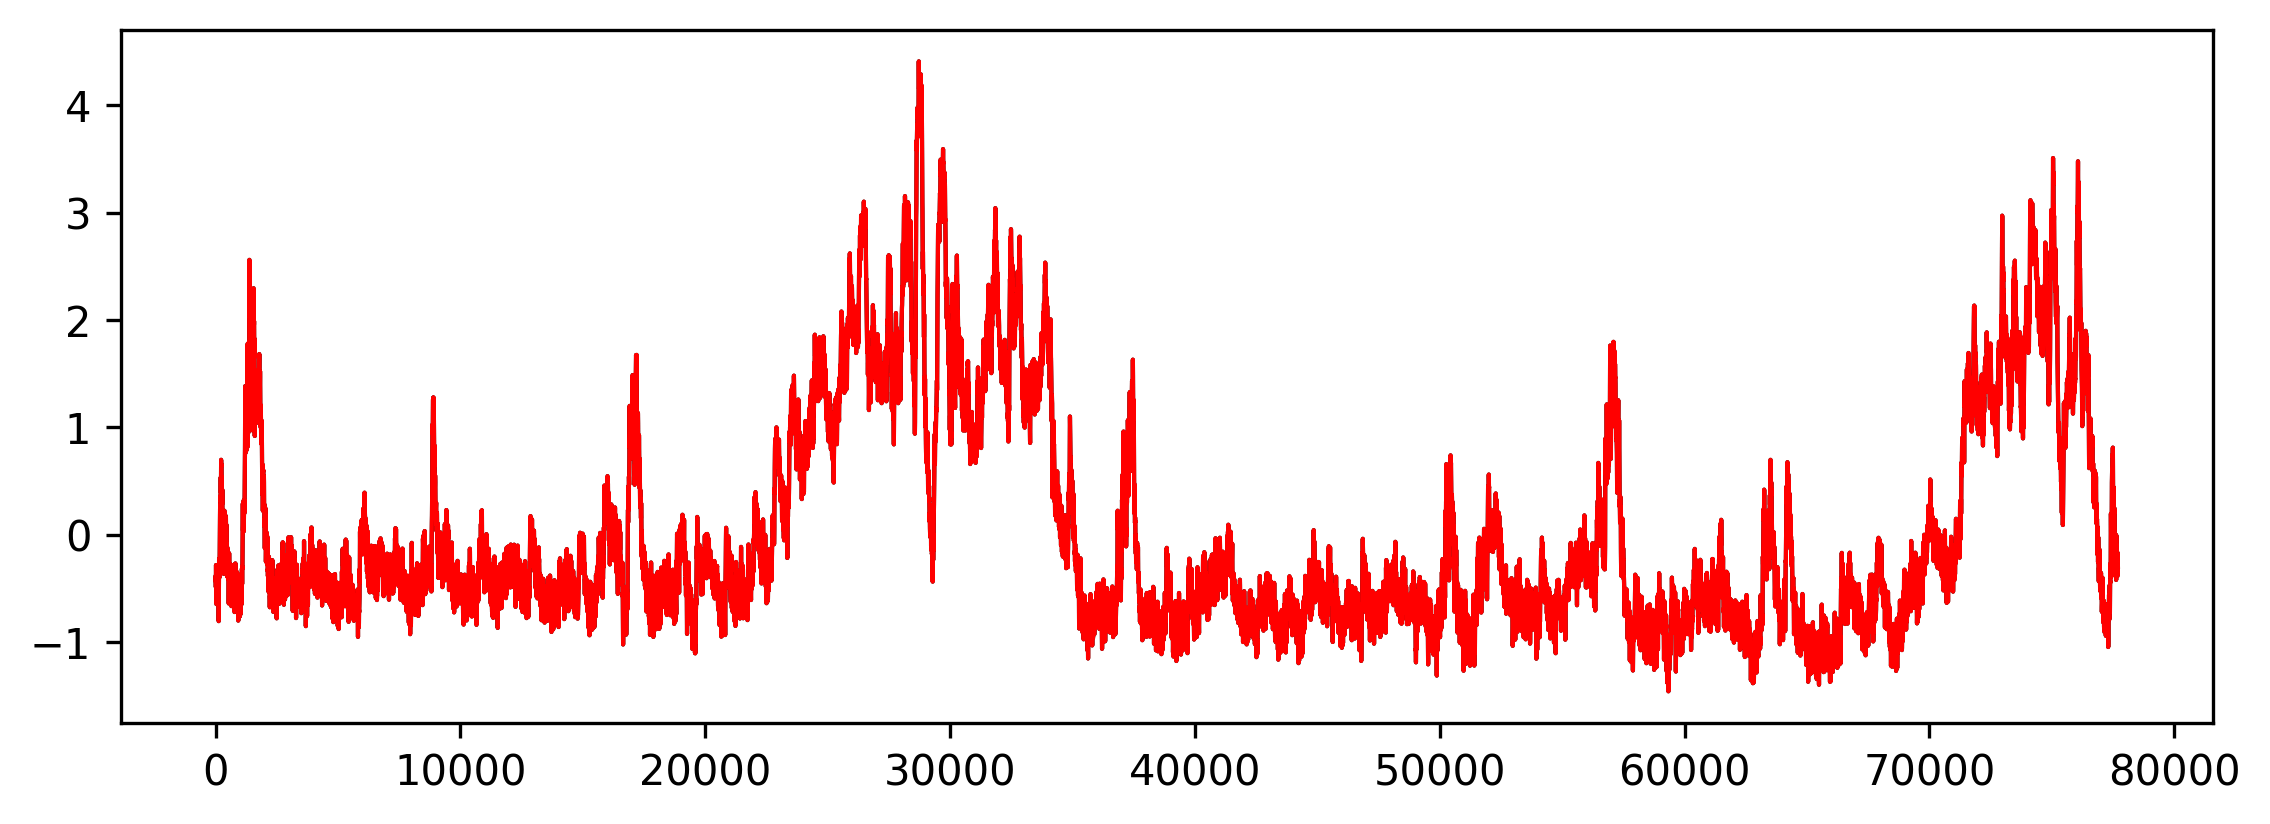

{'一共有多少眼动579'}
('rawdata\\mice5#\\fiber4\\mice5#_4fiber.txt', 'rawdata\\mice5#\\sleep4\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice5#\\sleep4\\modify_sleeprawdata.txt')


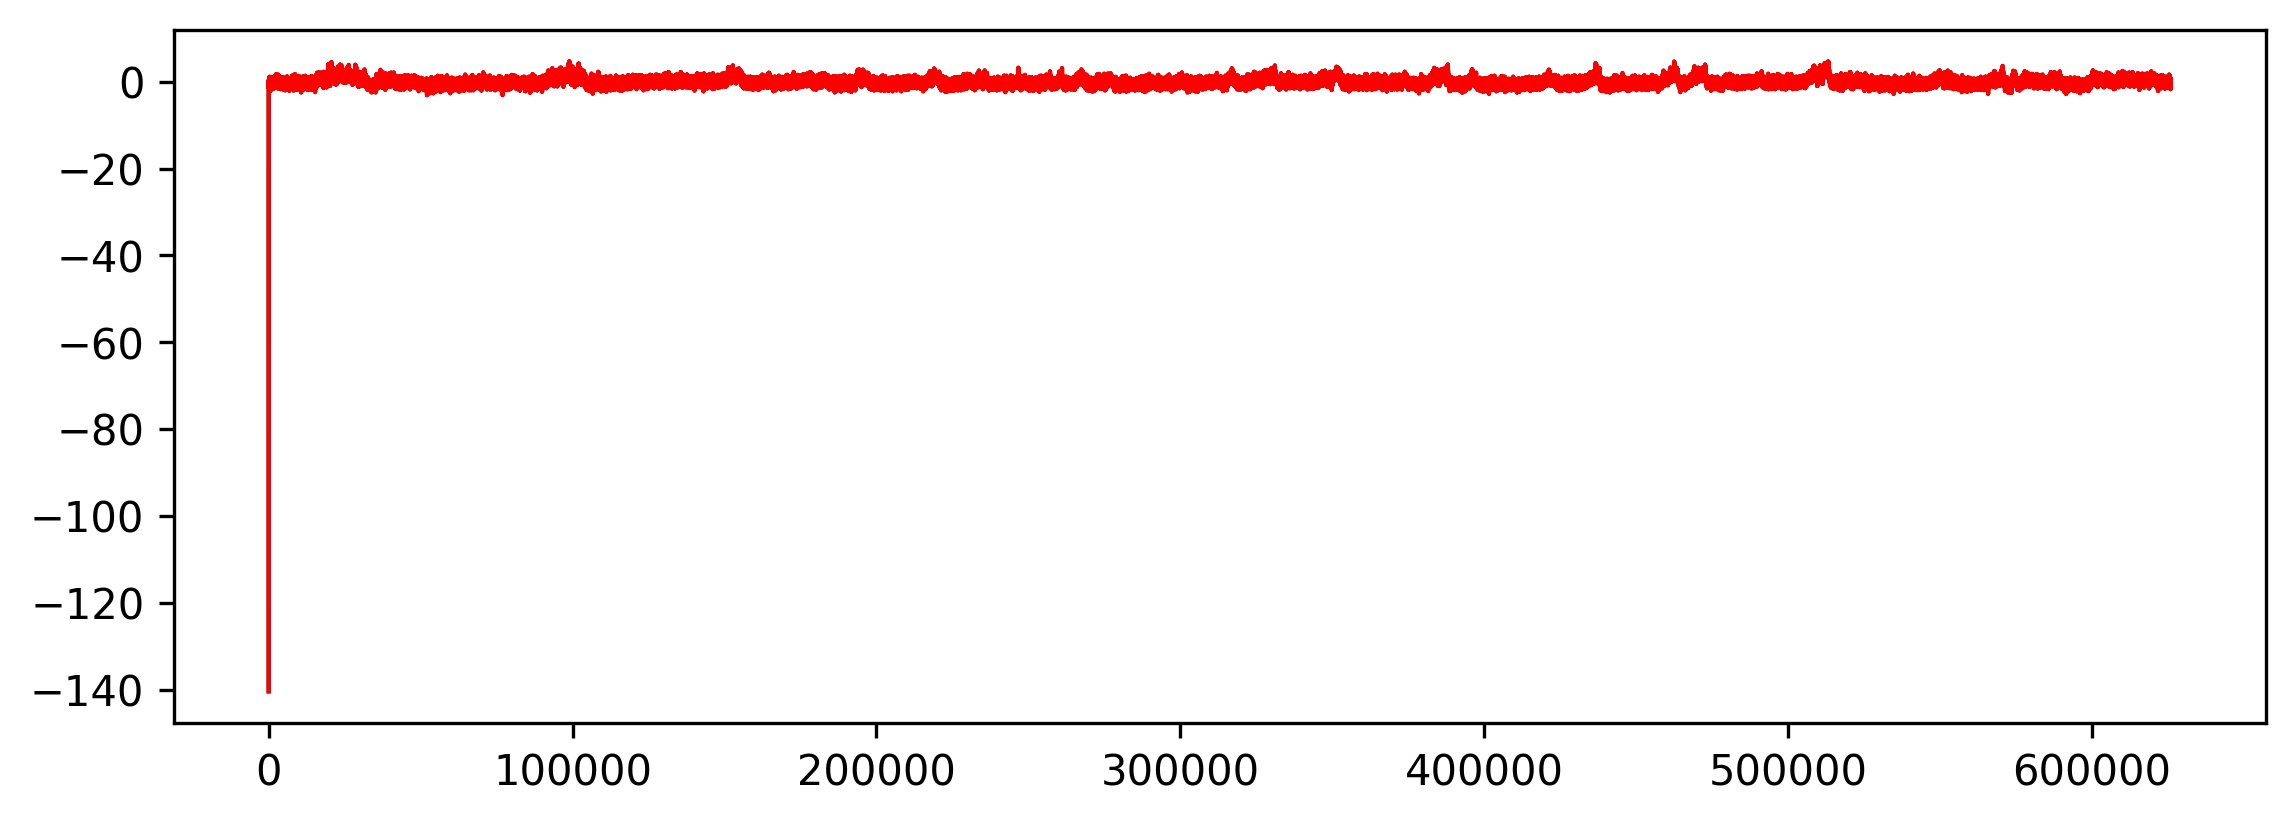

{'一共有多少眼动3845'}
('rawdata\\mice5#\\fiber5\\mice5#_5fiber.txt', 'rawdata\\mice5#\\sleep5\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice5#\\sleep5\\modify_sleeprawdata.txt')


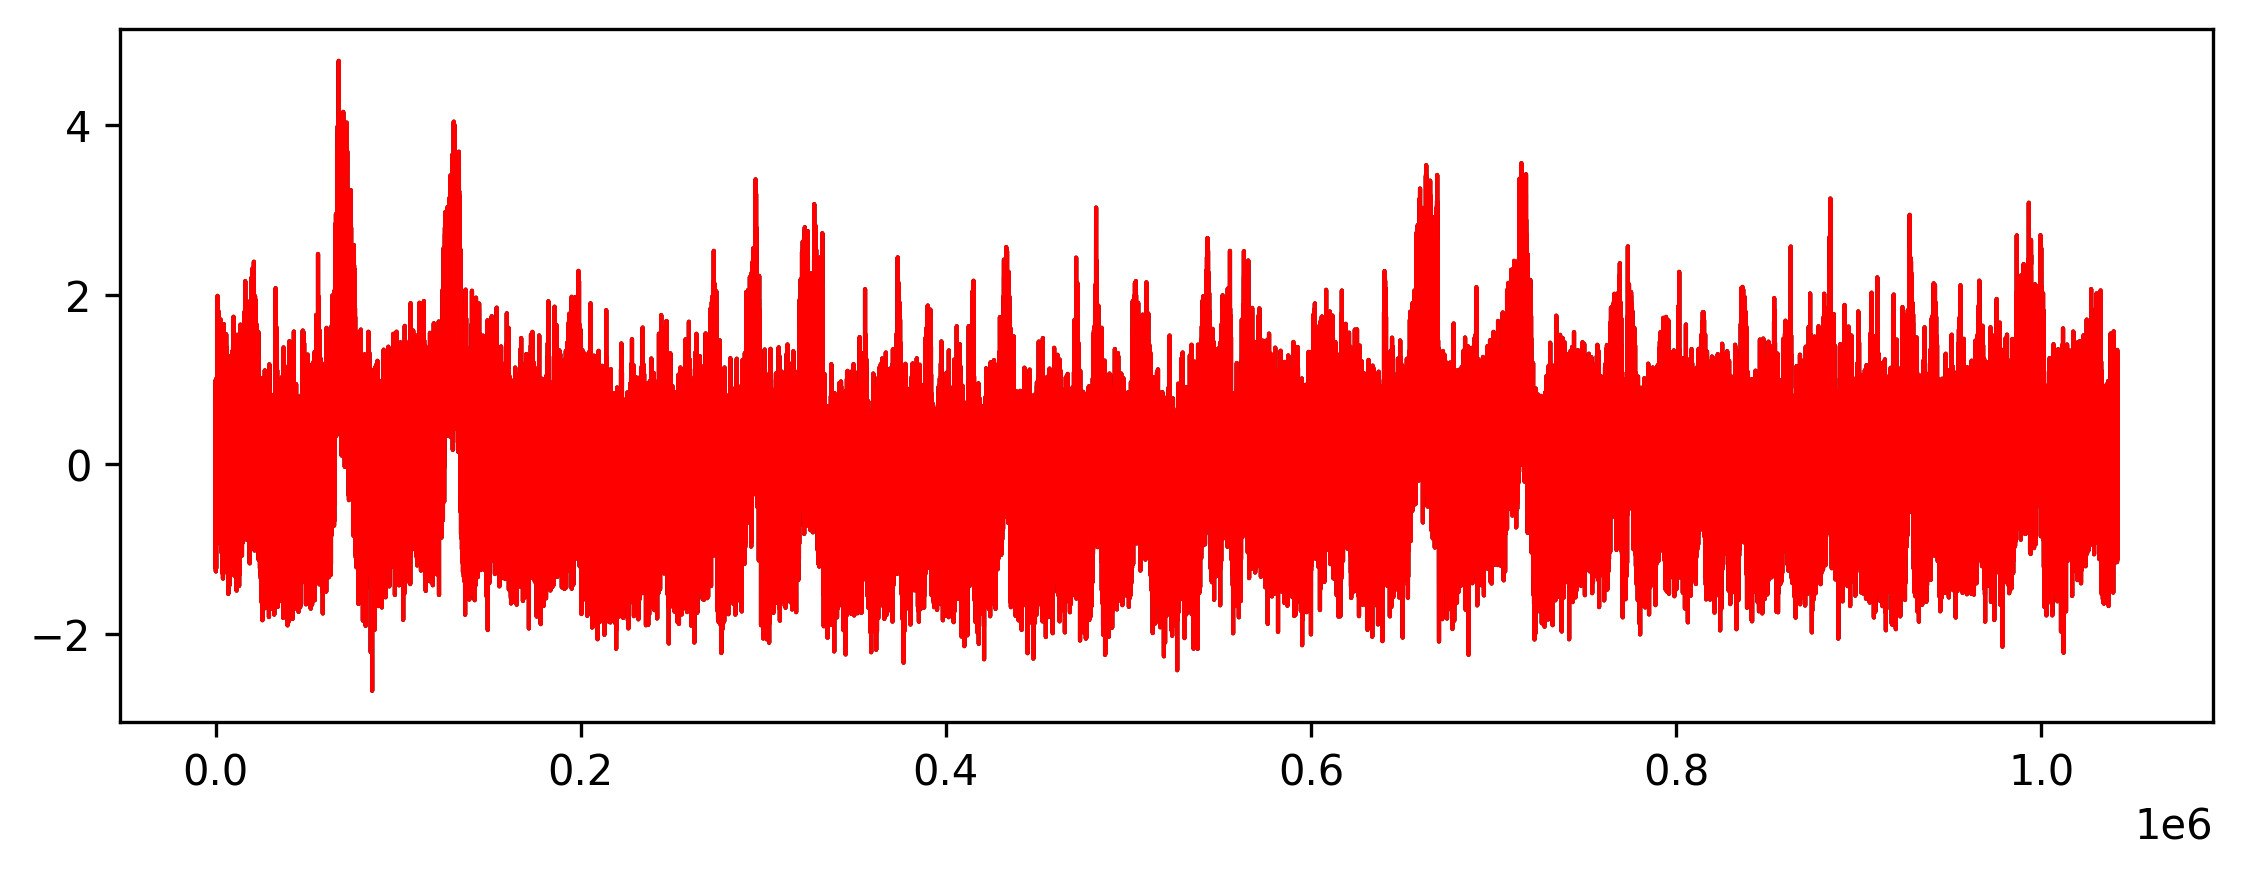

{'一共有多少眼动7076'}
trial数据结构(88, 60000)


In [13]:
###用于处理fiberphotometry记录到的Ca信号在睡眠转变期间的变化以及对应的眼动，并对横轴进行normalization
if __name__ == '__main__':
    ###匹配同一个trial对应的睡眠和钙信号数据，并找到REM转变点对应的钙信号作图
    root_dir=r'.\rawdata'
    newPath=r'.\NREM-REMwithEMs'
    if not Path.exists(Path(newPath)):
        os.makedirs(newPath)

    is_save='yes'
    max_epoch=15                                                                                                                                                                                                                                               ####设置满足条件的刺激前的世间长度
    fre_em,fre_Ca=500,100
    file_info,mice_mean_bef,mice_mean_aft,mice_name=[],[],[],[]

    all_trial={'trial_name':[],'mean_em_before':[],'mean_em_after':[],'mean_Ca_before':[],'mean_Ca_after':[]}
    all_cell={'cell':[],'mean_before':[],'mean_after':[],'em':[]}

    mean_stage=[]
    root = Path(root_dir)
    file_info = scan_sort(root, file_info)
    df = pd.DataFrame(file_info, columns=['filename', 'ext', 'dir'])

    trans_number=[]
    fiber_path,FFT_path,EM_path=[],[],[]
    for fname, dir in zip(df.filename, df.dir):
        path= os.path.join(dir, fname)
        if path.endswith('fiber.txt'):
            fiber_path.append(path)
        if path.endswith('cFFT.txt'):
            FFT_path.append(path)
        if path.endswith('modify_sleeprawdata.txt'):
            EM_path.append(path)
    fiber_sleep=[a for a in zip(fiber_path,FFT_path,EM_path)]

    for i in range(len(fiber_sleep)):
        print(fiber_sleep[i])
        fiber_mice(fiber_sleep[i])    ###可以做REM_off和t_pREM两种条件的钙信号数据

        # break

    print("trial数据结构{}".format(np.array(all_cell['cell']).shape))

    if np.array(all_cell['cell']).shape[0]==0:
        print('运行已结束：没有找到满足条件的数据')
        sys.exit(1)

有眼动的trial个数：70,无眼动的trial个数： 18


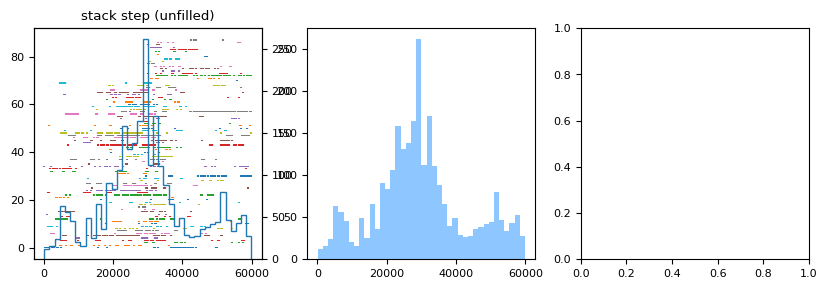

In [14]:
np.save(newPath+'\\all_cell.npy', all_cell)

##将眼动二值化，转化为raster plot; The raster plot of the em activity
em_index_arr=np.array(all_cell['em'])

em_raster=[]
for i in em_index_arr:
    em_raster_i=[n[0] for n in enumerate(i) if n[1]==1]
    em_raster.append(em_raster_i)

arr_withEM,arr_withEM_ind,arr_withoutEM,arr_withoutEM_ind=[],[],[],[]
for ind_i, em_i in enumerate(em_raster):
    if np.all(np.array(em_i)>=30000):
        arr_withoutEM.append(em_i)
        arr_withoutEM_ind.append(ind_i)
    else:
        arr_withEM.append(em_i)
        arr_withEM_ind.append(ind_i)

em_raster=arr_withEM+arr_withoutEM
print(f'有眼动的trial个数：{len(arr_withEM)},无眼动的trial个数： {len(arr_withoutEM)}')

# print(em_index_arr.shape)
# raster_tail=np.ones((em_index_arr.shape[0],1))
# em_raster_new=np.concatenate((em_index_arr,raster_tail),axis=1)
# em_raster_new=np.concatenate((raster_tail,em_raster_new),axis=1)

if is_save=='no':
    np.save(newPath+'\\em_raster.npy',em_index_arr)
###如果已经保存作图数据，则直接运行一下代码即可，无需从头作图
# root_dir=r'H:\EMdata\fiber photometry\OMNactivity_sleep\sleep_fiber\60s_normalized_time\REM-wake'
# em_index_arr=np.load(root_dir+'\\em_raster.npy', allow_pickle=True)
raster_plot(em_raster,len(em_index_arr),newPath)  ###defualt: dataset_type=list

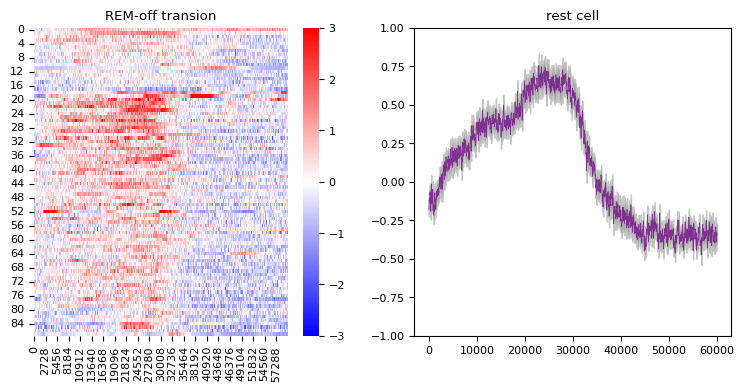

运行花费时间4.695604300000014


In [15]:
start = time.perf_counter()

mean_before=np.array(all_cell['mean_before'])
mean_after=np.array(all_cell['mean_after'])
# error_bar(mean_before,mean_after)

df_bef_aft=pd.DataFrame(zip(mean_before,mean_after))
df_bef_aft.columns=['cell_before','cell_after']
# df_bef_aft.to_excel(out_path+'\\ave_bef_aft.xlsx')

cell_map=[de_sampling(x,200) for x in all_cell['cell']]
cell_map_EM=np.array(all_cell['cell'])[arr_withEM_ind]
cell_map_nonEM=np.array(all_cell['cell'])[arr_withoutEM_ind]

sort_cell_map_EM = sorted(cell_map_EM, key=lambda x:np.mean(x), reverse=True)
sort_cell_map_nonEM = sorted(cell_map_nonEM, key=lambda x:np.mean(x), reverse=True)
all_neurons=np.concatenate((sort_cell_map_nonEM,sort_cell_map_EM),axis=0)
all_neurons_map=np.array(all_neurons)[:,1:]

plt.figure(figsize=(9,4))

plt.subplot(121);sns.heatmap(all_neurons_map,vmax=3, vmin=-3, cmap='bwr');plt.title('REM-off transion')

ave_cell=np.mean(all_neurons_map,axis=0)
# print(ave_cell)

std_cell=np.std(all_neurons_map,axis=0)/(math.sqrt(len(cell_map)))
# print(std_cell)

plt.subplot(122);plt.plot(ave_cell,linewidth=0.5,color='#7e318e');plt.title('rest cell')
plt.subplot(122);plt.fill_between(range(len(ave_cell)),ave_cell-std_cell,ave_cell+std_cell,color='black', alpha=0.2, label='Ca2+_reaponse(Z-score)')
plt.subplot(122);plt.ylim(-1,1)

if is_save=='yes':
    np.save(newPath+'\\cell_map.npy',all_neurons_map)
    # pd.DataFrame(cell_map).to_csv(newPath+'\\'+'cell_map.csv')
    plt.savefig(newPath+'\\'+'REM-wake.jpg',bbox_inches='tight')
plt.show()

end = time.perf_counter()
print('运行花费时间{}'.format(end - start))